In [1]:
import os

import jax
from jax import random
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import root_scalar

from pydd.analysis import (
    calculate_SNR,
    get_match_pads,
    loglikelihood_fft
)
from pydd.binary import *
from pydd.noise import S_n_LISA as S_n, f_range_LISA as F_RANGE_NOISE

Array = jnp.ndarray

Set up astrophysical system from paper

In [9]:
GAMMA_S_PBH = jnp.array(7 / 3)
M_1 = jnp.array(1e3 * MSUN)
M_2 = jnp.array(1.4 * MSUN)
M_CHIRP = get_M_chirp(M_1, M_2)
Q = M_2 / M_1
GAMMA_S = GAMMA_S_PBH
RHO_6 = 5.448e15 * MSUN / PC ** 3# * 1e-3
TT_C = jnp.array(0.0)
F_C = get_f_isco(M_1)
PHI_C = jnp.array(0.0)
DD_D = DynamicDress(
    GAMMA_S,
    RHO_6,
    get_M_chirp(M_1, M_2),
    M_2 / M_1,
    PHI_C,
    tT_c=TT_C,
    dL=jnp.array(76e6 * PC),
    f_c=get_f_isco(M_1),
)

# Get f_range
T_OBS = 5 * YR
F_RANGE_D = get_f_range(DD_D, T_OBS)

# Choose frequency grid and get padding needed for `ifft`
FS = jnp.linspace(*F_RANGE_D, 100_000)
PAD_LOW, PAD_HIGH = get_match_pads(FS)

Slightly altered version of `get_loglikelihood_fn_v`

In [10]:
def get_loglikelihood_fn_v(dd_s, f_l, f_h, n_f):
    """
    x: parameter point
    dd_s: signal system
    """
    # Unpack parameters into dark dress ones
    fs = jnp.linspace(f_l, f_h, n_f)
    pad_low, pad_high = get_match_pads(fs)

    def _ll(x):
        # The next line is different than in utils.py
        dd_h = VacuumBinary(x * MSUN, dd_s.Phi_c, dd_s.tT_c, dd_s.dL, dd_s.f_c)
        return loglikelihood_fft(dd_h, dd_s, fs, pad_low, pad_high)

    return _ll

# Create likelihood function for the values of `DD_D` and `F_RANGE_D` above
# The `*` in `*F_RANGE_D` is called the splat operator.
ll_fn_v = get_loglikelihood_fn_v(DD_D, *F_RANGE_D, n_f=100_000)

Calculate log likelihood over grid of chirp masses. The grid I use here has a narrower range than the bracket in `fit_v`.

In [11]:
xs = jnp.linspace(M_CHIRP / MSUN, M_CHIRP / MSUN + 1e-1, 200)
lls = []
for x in xs:
    lls.append(ll_fn_v(x))
lls = jnp.array(lls)

Text(0.5, 1.0, '$m_1 = 1000\\, \\mathrm{M}_\\odot$, $m_2 = 1.4\\, \\mathrm{M}_\\odot$, $\\gamma_s = 2.33333$, $\\rho_6 = 0.5448 \\times 10^{16}\\, \\mathrm{M}_\\odot / \\mathrm{pc}^3$')

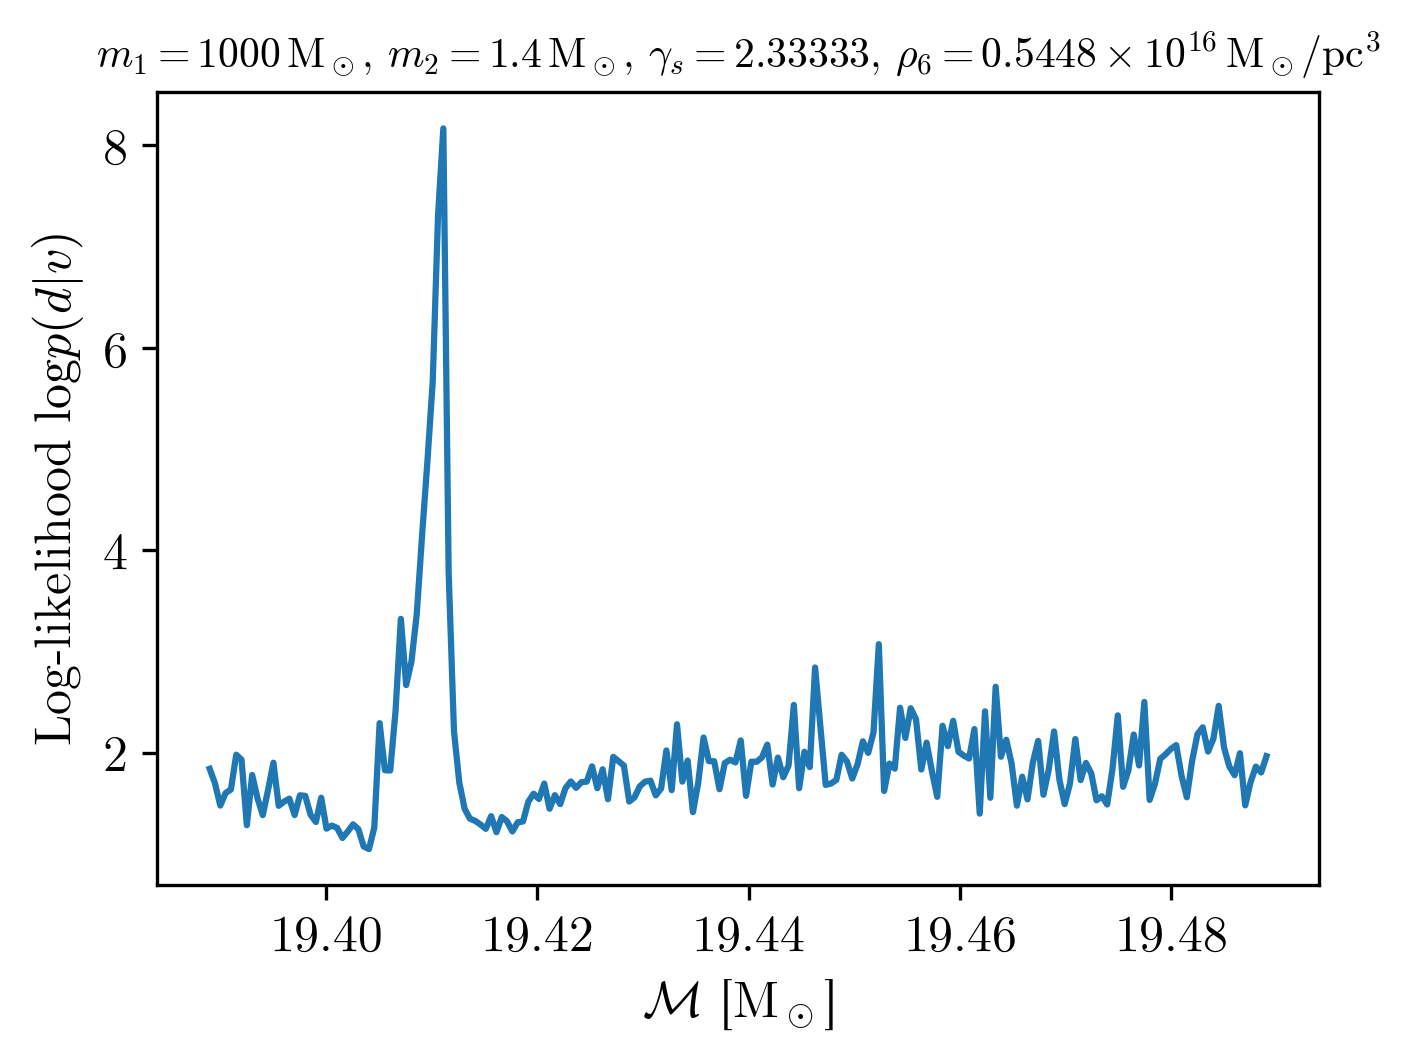

In [12]:
plt.plot(xs, lls)
plt.xlabel(r"$\mathcal{M}$ [M$_\odot$]")
plt.ylabel("Log-likelihood $\log p(d | v)$")
RHO_6T = RHO_6 / (1e16 * MSUN / PC ** 3)
plt.title(
    (r"$m_1 = %g\, \mathrm{M}_\odot$, " % (M_1 / MSUN))
    + (r"$m_2 = %g\, \mathrm{M}_\odot$, " % (M_2 / MSUN))
    + (r"$\gamma_s = %g$, " % GAMMA_S)
    + (r"$\rho_6 = %g \times 10^{16}\, \mathrm{M}_\odot / \mathrm{pc}^3$" % RHO_6T),
    fontsize=10,
)

In [8]:
(DD_D.M_chirp / MSUN, DD_D.M_chirp / MSUN + 1e-1)

(DeviceArray(19.38899524, dtype=float64, weak_type=True),
 DeviceArray(19.48899524, dtype=float64, weak_type=True))